In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers, optimizers
from sklearn.model_selection import train_test_split
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



In [2]:
# https://www.kaggle.com/ealaxi/paysim1
data = pd.read_csv(r'C:\Users\wanto\OneDrive\바탕 화면\데이터분석\데이터 분석\DATA\\PS_20174392719_1491204439457_log.csv')

데이터는 Paysim이라는 회사에서 시뮬레이터를 통해 생긴 인조 데이터

In [3]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
'''
step : 1 = 한 시간, 24 = 하루 744 = 31일
type : 결제, 송금, 인출, 입금, 차변(대출)
amount : 현지통화 거래금액
nameOrig : 거래 고객(보낸 사람)
oldbalanceOrig : 거래 전 초기 잔액(보낸 사람 거래전 잔액)
newbalanceOrig : 거래 후 잔액(보낸 사람 거래 후 잔액)
nameDest : 거래 수취인(받는 사람)
oldbalanceDest : 거래 전 잔액(받는 사람 거래전 잔액)
newbalanceDest : 거래 후 잔액(받는 시림 가레후 잔액)

isFraud (target) : 1 == 이상 거래
'''

'\nstep : 1 = 한 시간, 24 = 하루 744 = 31일\ntype : 결제, 송금, 인출, 입금, 차변(대출)\namount : 현지통화 거래금액\nnameOrig : 거래 고객(보낸 사람)\noldbalanceOrig : 거래 전 초기 잔액(보낸 사람 거래전 잔액)\nnewbalanceOrig : 거래 후 잔액(보낸 사람 거래 후 잔액)\nnameDest : 거래 수취인(받는 사람)\noldbalanceDest : 거래 전 잔액(받는 사람 거래전 잔액)\nnewbalanceDest : 거래 후 잔액(받는 시림 가레후 잔액)\n\nisFraud (target) : 1 == 이상 거래\n'

# EDA

In [4]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.isnull().sum() # null 값은 없다

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [8]:
data['isFraud'].value_counts()#불균형데이터 oversampling 필요

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
8213 / (6354407 + 8213) # 이상 거래 비율이 0.1프로임

0.001290820448180152

In [10]:
data['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [11]:
print(data.groupby('type').get_group('PAYMENT')['isFraud'].sum())
print(data.groupby('type').get_group('CASH_OUT')['isFraud'].sum())
print(data.groupby('type').get_group('CASH_IN')['isFraud'].sum())
print(data.groupby('type').get_group('TRANSFER')['isFraud'].sum())
print(data.groupby('type').get_group('DEBIT')['isFraud'].sum())

0
4116
0
4097
0


In [12]:
print(data.groupby('type').get_group('CASH_OUT')['isFraud'].sum()/(len(data.groupby('type').get_group('CASH_OUT'))))
print(data.groupby('type').get_group('TRANSFER')['isFraud'].sum()/(len(data.groupby('type').get_group('TRANSFER'))))

0.0018395530726256983
0.007687991758442811


In [13]:
'''
이상 거래는 인출과 송금에서 나타남
cash_out 이상 거래 비율은 0.1퍼
transfer 이상 거래 비율은 0.7퍼
'''

'\n이상 거래는 인출과 송금에서 나타남\ncash_out 이상 거래 비율은 0.1퍼\ntransfer 이상 거래 비율은 0.7퍼\n'

In [14]:
#필요 없어보이는 변수 삭제
data_drop = data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

data_clean = data_drop.loc[(data_drop.type == 'TRANSFER') | (data_drop.type == 'CASH_OUT')]
# 범주 변수를 연속형으로 바꿔주기
data_clean.loc[data_clean.type == 'TRANSFER', 'type'] = 0
data_clean.loc[data_clean.type == 'CASH_OUT', 'type'] = 1
data_clean.type = data_clean.type.astype(int)

- 거래 후 거래발생자 계좌 + 거래 금액 - 거래 전 거래발생자 계좌
- 거래 전 수취인 계좌  + 거래 금액 - 거래 후 수취인 계좌
- 이게 0이 아니면 거래에 오류가 있는 것 -> 이상 거래와 연관이 있을까

In [19]:
data_clean['errorBalanceOrig'] = data_clean.newbalanceOrig + data_clean.amount - data_clean.oldbalanceOrg
data_clean['errorBalanceDest'] = data_clean.oldbalanceDest + data_clean.amount - data_clean.newbalanceDest

In [20]:
data_clean

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.00,0.0,0.00,0.00,1,0.00,1.810000e+02
3,1,1,181.00,181.00,0.0,21182.00,0.00,1,0.00,2.136300e+04
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,0,213808.94,1.827035e+05
19,1,0,215310.30,705.00,0.0,22425.00,0.00,0,214605.30,2.377353e+05
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,0,300850.89,-2.401220e+06
...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,1,0.00,0.000000e+00
6362616,743,0,6311409.28,6311409.28,0.0,0.00,0.00,1,0.00,6.311409e+06
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0.00,1.000000e-02
6362618,743,0,850002.52,850002.52,0.0,0.00,0.00,1,0.00,8.500025e+05


In [21]:
data_clean['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

## 시각화

In [22]:
data_transfer = data_clean.groupby('type').get_group(0)
data_cashout = data_clean.groupby('type').get_group(1)

In [23]:
data_cashout_fraud = data_cashout.groupby('isFraud').get_group(1)
data_cashout_nonfraud = data_cashout.groupby('isFraud').get_group(0)
data_transfer_fraud = data_transfer.groupby('isFraud').get_group(1)
data_transfer_nonfraud = data_transfer.groupby('isFraud').get_group(0)

In [24]:
data_cashout_fraud

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
3,1,1,181.00,181.00,0.0,21182.00,0.00,1,0.00,2.136300e+04
252,1,1,2806.00,2806.00,0.0,26202.00,0.00,1,0.00,2.900800e+04
681,1,1,20128.00,20128.00,0.0,6268.00,12145.85,1,0.00,1.425015e+04
724,1,1,416001.33,0.00,0.0,102.00,9291619.62,1,416001.33,-8.875516e+06
970,1,1,1277212.77,1277212.77,0.0,0.00,2444985.19,1,0.00,-1.167772e+06
...,...,...,...,...,...,...,...,...,...,...
6362611,742,1,63416.99,63416.99,0.0,276433.18,339850.17,1,0.00,0.000000e+00
6362613,743,1,1258818.82,1258818.82,0.0,503464.50,1762283.33,1,0.00,-1.000000e-02
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,1,0.00,0.000000e+00
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0.00,1.000000e-02


In [25]:
cashout_nofraud_step = data_cashout_nonfraud['step']
cashout_fraud_step = data_cashout_fraud['step']
transfer_nofraud_step = data_transfer_nonfraud['step']
transfer_fraud_step = data_transfer_fraud['step']

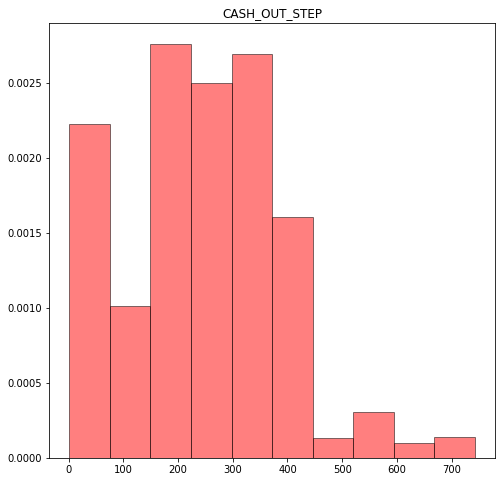

In [26]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
plt.hist(data_cashout['step'], 10, density=True, color='r', alpha=0.5, edgecolor='k') 

plt.title('CASH_OUT_STEP')
plt.show()
# 한달 초중반에 인출이 많고 후반에 눈에 띄게 작아짐

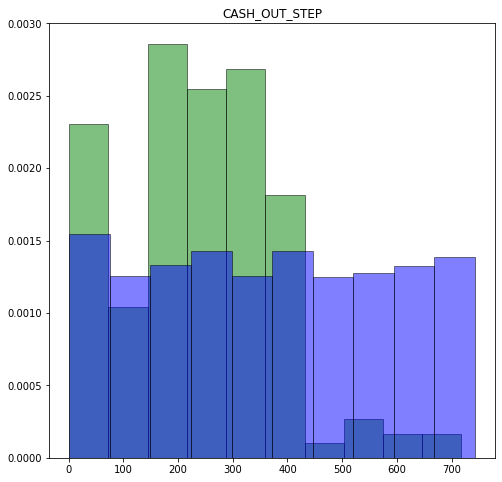

In [27]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
plt.hist(cashout_nofraud_step, 10, density=True, color='g', alpha=0.5, edgecolor='k') # 초록이 이상거래 아님
plt.hist(cashout_fraud_step, 10, density=True, color='b', alpha=0.5, edgecolor='k') # 파랑이 이상거래
 
plt.title('CASH_OUT_STEP')
plt.show()
# 이상 거래는 시기와 상관없음

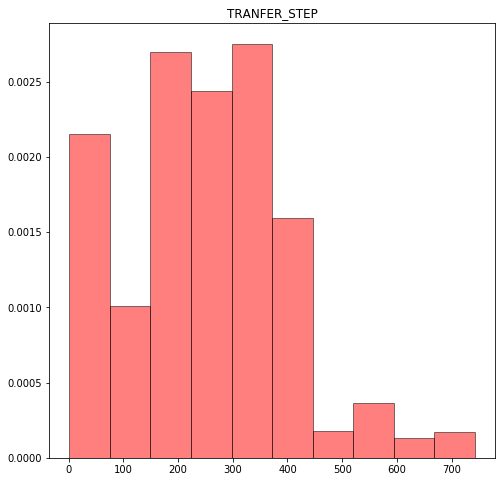

In [28]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
plt.hist(data_transfer['step'], 10, density=True, color='r', alpha=0.5, edgecolor='k') 

plt.title('TRANFER_STEP')
plt.show()
# 한달 초중반에 인출이 많고 후반에 눈에 띄게 작아짐

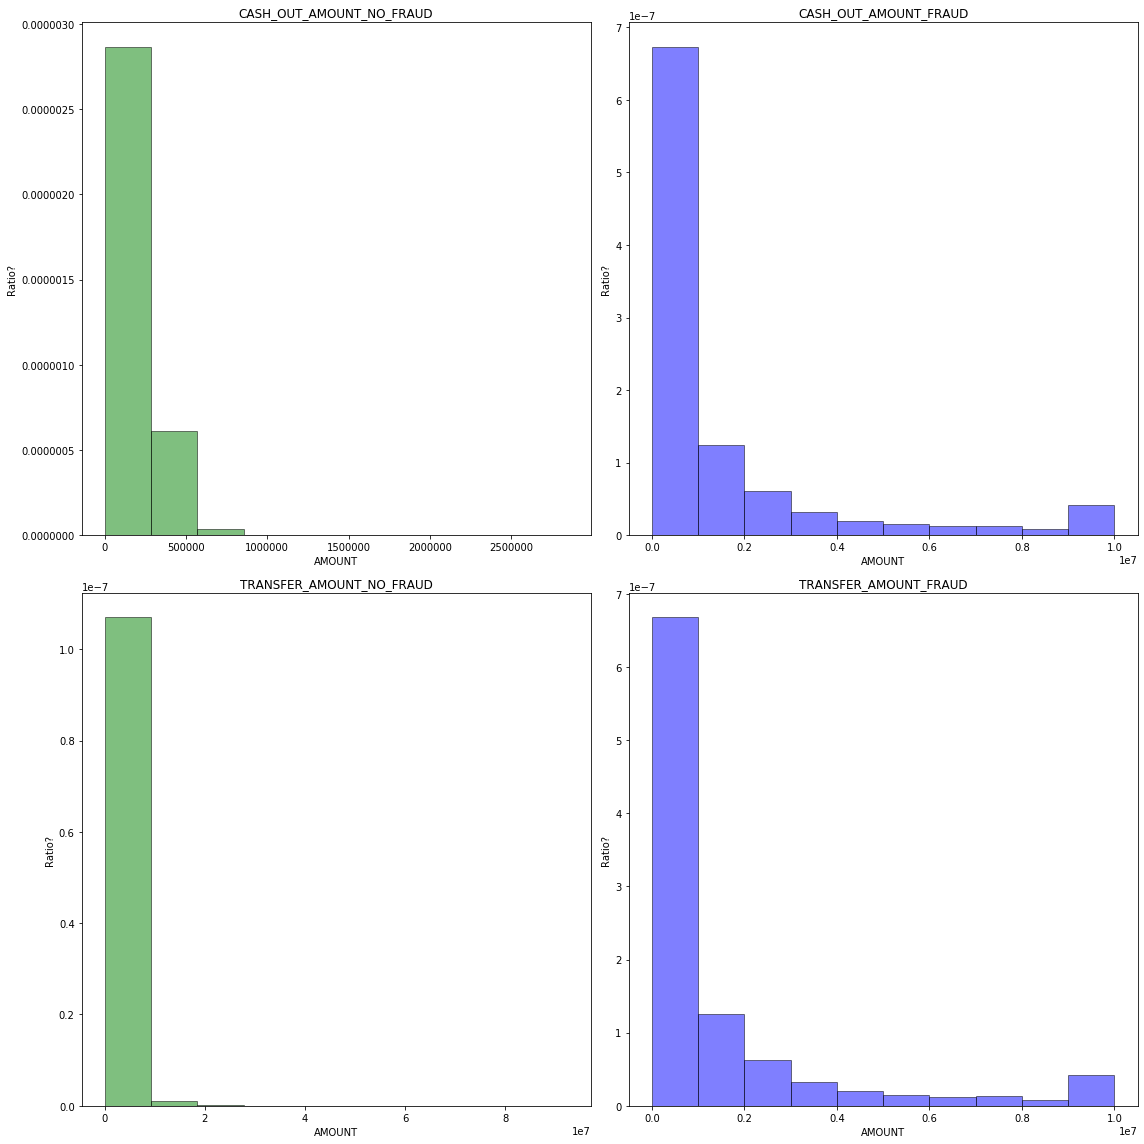

In [29]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')


plt.subplot(2, 2, 1)                # nrows=1, ncols=2, index=1
plt.hist(data_cashout_nonfraud['amount'], 10, density=True, color='g', alpha=0.5, edgecolor='k') # 초록이 이상거래 아님
 
plt.title('CASH_OUT_AMOUNT_NO_FRAUD')
plt.xlabel('AMOUNT')
plt.ylabel('Ratio?')

plt.subplot(2, 2, 2)                # nrows=1, ncols=2, index=2
plt.hist(data_cashout_fraud['amount'], 10, density=True, color='b', alpha=0.5, edgecolor='k') # 파랑이 이상거래
 
plt.title('CASH_OUT_AMOUNT_FRAUD')
plt.xlabel('AMOUNT')
plt.ylabel('Ratio?')


plt.subplot(2, 2, 3)                # nrows=1, ncols=2, index=1
plt.hist(data_transfer_nonfraud['amount'], 10, density=True, color='g', alpha=0.5, edgecolor='k') # 초록 이상거래 아님
 
plt.title('TRANSFER_AMOUNT_NO_FRAUD')
plt.xlabel('AMOUNT')
plt.ylabel('Ratio?')

plt.subplot(2, 2, 4)                # nrows=1, ncols=2, index=2
plt.hist(data_transfer_fraud['amount'], 10, density=True, color='b', alpha=0.5, edgecolor='k') # 파랑 이상거래
 
plt.title('TRANSFER_AMOUNT_FRAUD')
plt.xlabel('AMOUNT')
plt.ylabel('Ratio?')

plt.tight_layout()
plt.show()

In [30]:
'''
cash_out
nofraud는 100만을 넘는 경우가 없다. 대부분 50만 이하이다.
반면 fraud는 200만~ 300만 이하의 경우가 대부분이고 1000만까지 금액이 다양하다.

transfer
nofraud는 100만을 넘는 경우가 있지만 대부분 100만 이하이다.
반면 fraud는 200만~ 300만 이하의 경우가 대부분이고 1000만까지 금액이 다양하다.
'''

'\ncash_out\nnofraud는 100만을 넘는 경우가 없다. 대부분 50만 이하이다.\n반면 fraud는 200만~ 300만 이하의 경우가 대부분이고 1000만까지 금액이 다양하다.\n\ntransfer\nnofraud는 100만을 넘는 경우가 있지만 대부분 100만 이하이다.\n반면 fraud는 200만~ 300만 이하의 경우가 대부분이고 1000만까지 금액이 다양하다.\n'

In [31]:
print('cash_out_nofraud 최대 :', data_cashout_nonfraud['amount'].max())
print('cash_out_fraud 최대 :', data_cashout_fraud['amount'].max())
print('cash_out_nofraud 평균 :', data_cashout_nonfraud['amount'].mean())
print('cash_out_fraud 평균 :', data_cashout_fraud['amount'].mean())
print('\n')
print('transfer_nofraud 최대 :', data_cashout_nonfraud['amount'].max())
print('transfer_fraud 최대 :', data_transfer_fraud['amount'].max())
print('transfer_nofraud 평균 :', data_transfer_nonfraud['amount'].mean())
print('transfer_fraud 평균 :', data_transfer_fraud['amount'].mean())

cash_out_nofraud 최대 : 2847566.62
cash_out_fraud 최대 : 10000000.0
cash_out_nofraud 평균 : 173917.15575138968
cash_out_fraud 평균 : 1455102.5859645216


transfer_nofraud 최대 : 2847566.62
transfer_fraud 최대 : 10000000.0
transfer_nofraud 평균 : 906229.0078121366
transfer_fraud 평균 : 1480891.6729338474


<Figure size 432x288 with 0 Axes>

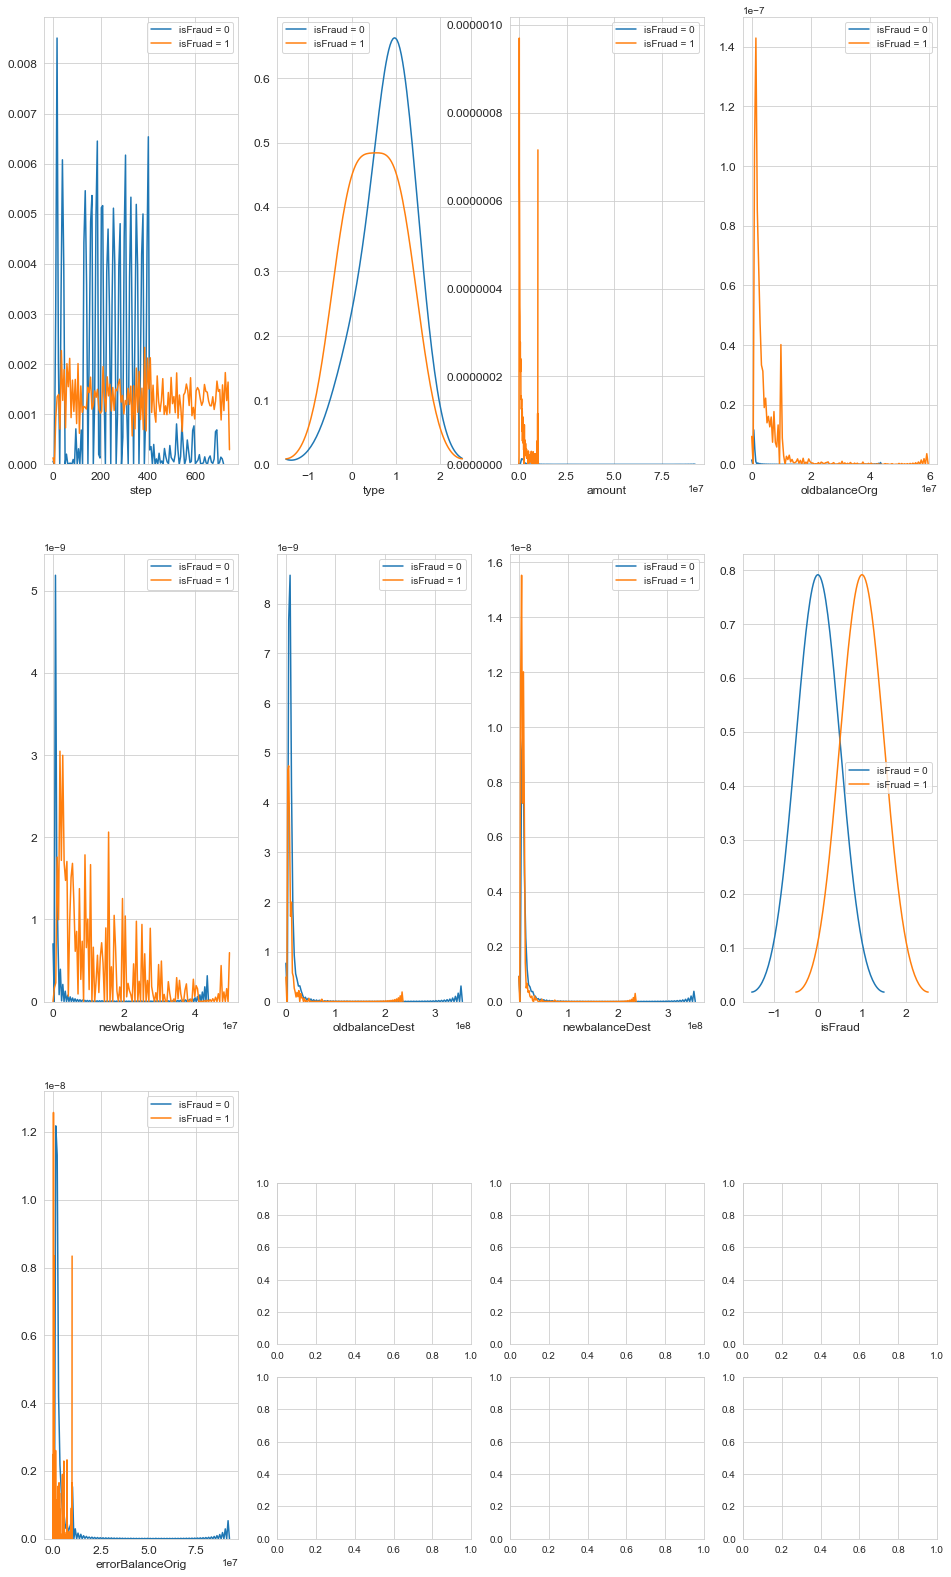

In [34]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


var = data_clean.columns.values[:-1] 
i = 0
t0 = data_clean.loc[data_clean['isFraud'] == 0] # Class : 0 인 행만 추출
t1 = data_clean.loc[data_clean['isFraud'] == 1] # Class : 1 인 행만 추출

sns.set_style('whitegrid') # 그래프 스타일 지정
plt.figure()
fig, ax = plt.subplots(8, 4, figsize = (16, 28)) # 축 지정

for feature in var:
    i += 1
    plt.subplot(3, 4, i) 
    sns.kdeplot(t0[feature], bw = 0.5, label = "isFraud = 0")
    sns.kdeplot(t1[feature], bw = 0.5, label = "isFruad = 1")
    plt.xlabel(feature, fontsize = 12) # 라벨 속성값
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show();

# SMOTE 

In [5]:
X = (data_clean.iloc[:, data_clean.columns != 'isFraud'])
y = (data_clean.iloc[:, data_clean.columns == 'isFraud'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (2770409, 7)
Shape of y: (2770409, 1)


In [29]:
X = np.array(data_clean.iloc[:, data_clean.columns != 'isFraud'])
y = np.array(data_clean.iloc[:, data_clean.columns == 'isFraud'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (2770409, 7)
Shape of y: (2770409, 1)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (2216327, 7)
Number transactions y_train dataset:  (2216327, 1)
Number transactions X_test dataset:  (554082, 7)
Number transactions y_test dataset:  (554082, 1)


In [7]:
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label:1")
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1-Score: ", F1_Score)

In [8]:
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
lgb_dtrain = lgb.Dataset(data = pd.DataFrame(X_train), label = pd.DataFrame(y_train)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = np.argmax(lgb_model.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model_predict) # 모델 분류 결과 평가

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 2216327, number of used features: 7
[LightGBM] [Info] Start training from score -0.002972
[LightGBM] [Info] Start training from score -5.820028
Model_Evaluation with Label:1
Accuracy:  0.9970672210972383
Precision:  1.0
Recall:  0.006723716381418093
F1-Score:  0.013357619914996965


In [33]:
# 기존의 X_train, y_train, X_test, y_test의 형태 확인
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (2216327, 7)
Number transactions y_train dataset:  (2216327, 1)
Number transactions X_test dataset:  (554082, 7)
Number transactions y_test dataset:  (554082, 1)


In [38]:
from imblearn.over_sampling import SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm = SMOTE(random_state = 42, ratio = 0.3) # SMOTE 알고리즘, 비율 증가
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) # Over Sampling 진행

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


Before OverSampling, counts of label '1': [6577]
Before OverSampling, counts of label '0': [2209750] 

After OverSampling, counts of label '1': 662925
After OverSampling, counts of label '0': 2209750


In [39]:
print("Before OverSampling, the shape of X_train: {}".format(X_train.shape)) # SMOTE 적용 이전 데이터 형태
print("Before OverSampling, the shape of y_train: {}".format(y_train.shape)) # SMOTE 적용 이전 데이터 형태
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape)) # SMOTE 적용 결과 확인
print('After OverSampling, the shape of y_train: {}'.format(y_train_res.shape)) # # SMOTE 적용 결과 확인

Before OverSampling, the shape of X_train: (2216327, 7)
Before OverSampling, the shape of y_train: (2216327, 1)
After OverSampling, the shape of X_train: (2872675, 7)
After OverSampling, the shape of y_train: (2872675,)


In [40]:
lgb_dtrain2 = lgb.Dataset(data = pd.DataFrame(X_train_res), label = pd.DataFrame(y_train_res)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param2 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model2 = lgb.train(params = lgb_param2, train_set = lgb_dtrain2) # 학습 진행
lgb_model2_predict = np.argmax(lgb_model2.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model2_predict) # 모델 분류 평가 결과

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2872675, number of used features: 7
[LightGBM] [Info] Start training from score -0.262364
[LightGBM] [Info] Start training from score -1.466337
Model_Evaluation with Label:1
Accuracy:  0.9978865944029945
Precision:  0.6076887447892543
Recall:  0.8019559902200489
F1-Score:  0.6914361001317523


# smote 비율 0.6

In [41]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm2 = SMOTE(random_state = 42, ratio = 0.6) # SMOTE 알고리즘, 비율 60%
X_train_res2, y_train_res2 = sm2.fit_sample(X_train, y_train.ravel()) # Over Sampling 진행

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res2==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res2==0)))

Before OverSampling, counts of label '1': [6577]
Before OverSampling, counts of label '0': [2209750] 

After OverSampling, counts of label '1': 1325850
After OverSampling, counts of label '0': 2209750


In [42]:
lgb_dtrain3 = lgb.Dataset(data = pd.DataFrame(X_train_res2), label = pd.DataFrame(y_train_res2)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param3 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res2))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model3 = lgb.train(params = lgb_param3, train_set = lgb_dtrain3) # 학습 진행
lgb_model3_predict = np.argmax(lgb_model3.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model3_predict) # 모델 분류 평가 결과

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3535600, number of used features: 7
[LightGBM] [Info] Start training from score -0.470004
[LightGBM] [Info] Start training from score -0.980829
Model_Evaluation with Label:1
Accuracy:  0.9881678163159966
Precision:  0.19592088998763907
Recall:  0.9688264058679706
F1-Score:  0.3259304955788608


# smote 비율 1

In [43]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm3 = SMOTE(random_state = 42) # SMOTE 알고리즘, Default: 동등
X_train_res3, y_train_res3 = sm3.fit_sample(X_train, y_train.ravel()) # Over Sampling 진행

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res3==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res3==0)))

Before OverSampling, counts of label '1': [6577]
Before OverSampling, counts of label '0': [2209750] 

After OverSampling, counts of label '1': 2209750
After OverSampling, counts of label '0': 2209750


In [44]:
lgb_dtrain4 = lgb.Dataset(data = pd.DataFrame(X_train_res3), label = pd.DataFrame(y_train_res3)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param4 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res3))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model4 = lgb.train(params = lgb_param4, train_set = lgb_dtrain4) # 학습 진행
lgb_model4_predict = np.argmax(lgb_model4.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model4_predict) # 모델 분류 평가 결과

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4419500, number of used features: 7
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
Model_Evaluation with Label:1
Accuracy:  0.9748899982313087
Precision:  0.1033792078568198
Recall:  0.9779951100244498
F1-Score:  0.18699234500087653


smote한 성능이 훨씬 낫고 비율은 0.3이 적당함

# BLSM

In [45]:
# BLSM (Borderline SMOTE)
from imblearn.over_sampling import BorderlineSMOTE

sm4 = BorderlineSMOTE(random_state = 42, sampling_strategy = 0.6) # BLSM 알고리즘 적용
X_train_res4, y_train_res4 = sm4.fit_sample(X_train, y_train.ravel()) # Over Sampling 적용

In [46]:
lgb_dtrain5 = lgb.Dataset(data = pd.DataFrame(X_train_res4), label = pd.DataFrame(y_train_res4)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param5 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res4))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model5 = lgb.train(params = lgb_param5, train_set = lgb_dtrain5) # 학습 진행
lgb_model5_predict = np.argmax(lgb_model5.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model5_predict) # 모델 분류 평가 결과

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3535600, number of used features: 7
[LightGBM] [Info] Start training from score -0.470004
[LightGBM] [Info] Start training from score -0.980829
Model_Evaluation with Label:1
Accuracy:  0.9843470822008294
Precision:  0.15372502706426533
Recall:  0.9547677261613692
F1-Score:  0.26481308807323894


# BLSM은 sampling_strategy=0.3일 때 가장 성능이 좋아보임

In [10]:
from imblearn.over_sampling import BorderlineSMOTE

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm5 = BorderlineSMOTE(random_state = 42, sampling_strategy = 0.3) # BLSM 알고리즘 적용
X_train_res5, y_train_res5 = sm5.fit_sample(X_train, y_train) # Over Sampling 적용

# print("After OverSampling, counts of label '1': {}".format(sum(y_train_res5==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train_res5==0)))

In [11]:
lgb_dtrain6 = lgb.Dataset(data = pd.DataFrame(X_train_res5), label = pd.DataFrame(y_train_res5)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param6 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res5))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model6 = lgb.train(params = lgb_param6, train_set = lgb_dtrain6) # 학습 진행
lgb_model6_predict = np.argmax(lgb_model6.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model6_predict) # 모델 분류 평가 결과

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2872675, number of used features: 7
[LightGBM] [Info] Start training from score -0.262364
[LightGBM] [Info] Start training from score -1.466337
Model_Evaluation with Label:1
Accuracy:  0.9973469630848864
Precision:  0.5330940988835726
Recall:  0.8172371638141809
F1-Score:  0.6452702702702703


이상 거래 탐지인 만큼 Recall의 중요도가 더 높기 때문에 smote 비율 0.3보다 BLSM 비율 0.3이 낫다.

In [13]:
import shap
explainer = shap.TreeExplainer(lgb_model6) # 트리 모델 Shap Value 계산 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [16]:
shap.initjs() # 자바스크립트 초기화 (그래프 초기화)
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X_test.iloc[1,:]) # 첫 번째 검증 데이터 인스턴스에 대해 Shap Value를 적용하여 시각화
# 빨간색이 영향도가 높으며, 파란색이 영향도가 낮음

In [17]:
shap.initjs() # 자바스크립트 초기화 (그래프 초기화)
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_test.iloc[1,:]) # 첫 번째 검증 데이터 인스턴스에 대해 Shap Value를 적용하여 시각화
# 빨간색이 영향도가 높으며, 파란색이 영향도가 낮음

In [18]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:1000, :], X_test.iloc[:1000, :]) 
# 1000개의 검증 데이터 셋에 대해서 적용

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000, :], X_test.iloc[:1000, :]) 
# 1000개의 검증 데이터 셋에 대해서 적용

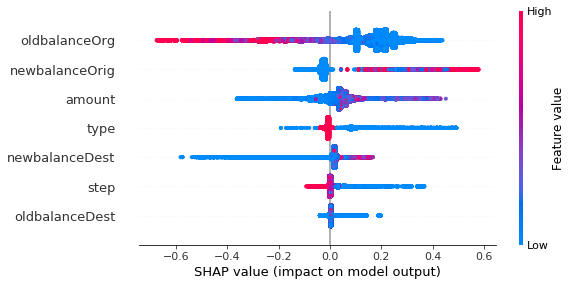

In [21]:
shap.summary_plot(shap_values[0], X_test)

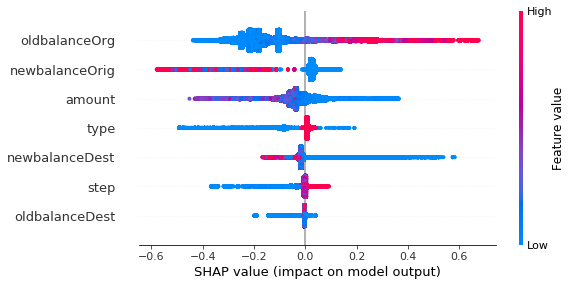

In [22]:
shap.summary_plot(shap_values[1], X_test)

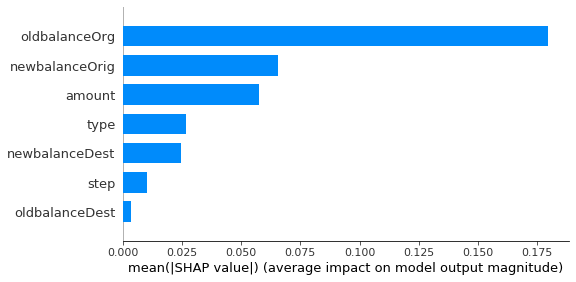

In [24]:
shap.summary_plot(shap_values[1], X_test, plot_type = "bar") # 각 변수에 대한 Shap Values의 절대값으로 중요도 파악

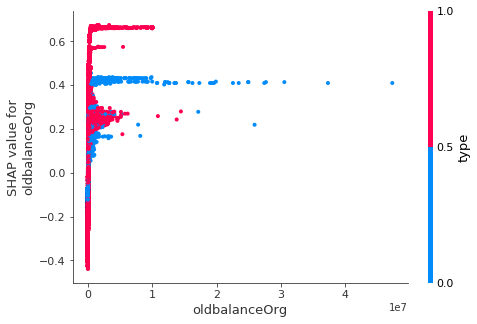

In [27]:
shap.dependence_plot("oldbalanceOrg", shap_values[1], X_test)

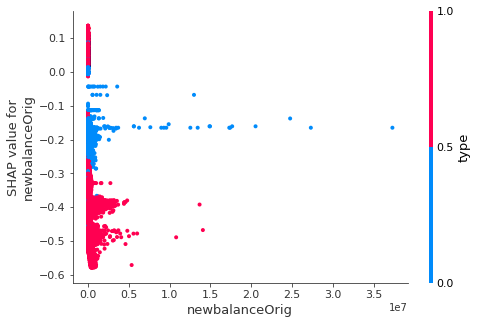

In [29]:
shap.dependence_plot("newbalanceOrig", shap_values[1], X_test)

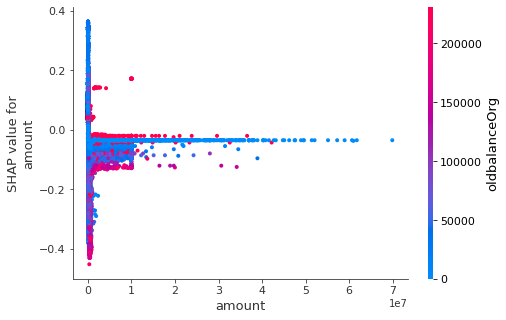

In [26]:
shap.dependence_plot("amount", shap_values[1], X_test)

In [ ]:
# BLSM을 이용해서 Oversampling 한 학습 데이터 셋 : X_train_res2, y_train_res2
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C = 1e+10) 
# sklearn 의 Logistic Regression은 기본적으로 Ridge 정규화가 포함되어 있기 때문에, 
# 정규화 텀을 억제하는 C를 크게 적용한다 (C:Inverse of regularization strength)
lr_model.fit(X_train_res, y_train_res) # 로지스틱 회귀 모형 학습
lr_predict = lr_model.predict(X_test) # 학습 결과를 바탕으로 검증 데이터를 예측
model_evaluation(y_test, lr_predict) # 모델 분류 평가 결과

In [51]:
np.sum(lr_predict==1)

19506

In [53]:
# 라쏘 로지스틱 회귀모형 학습
lasso_model = LogisticRegression() # Penalty = l1 Regularizer, C = 1.0 (Default))
lasso_model.fit(X_train_res, y_train_res) # 라쏘 로지스틱 회귀 모형 학습
lasso_predict = lasso_model.predict(X_test) # 학습 결과를 바탕으로 검증 데이터를 예측
model_evaluation(y_test, lasso_predict) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.966914644402814
Precision:  0.0720291192453604
Recall:  0.85880195599022
F1-Score:  0.1329107936808249


In [54]:
np.sum(lasso_predict==1)

19506

In [55]:
# 릿지 로지스틱 회귀모형 학습
ridge_model = LogisticRegression(penalty = 'l2') # Default = LogisticRegression()
ridge_model.fit(X_train_res, y_train_res) # 릿지 로지스틱 회귀 모형 학습
ridge_predict = ridge_model.predict(X_test) # 학습 결과를 바탕으로 검증 데이터를 예측
model_evaluation(y_test, ridge_predict) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.966914644402814
Precision:  0.0720291192453604
Recall:  0.85880195599022
F1-Score:  0.1329107936808249


In [56]:
np.sum(ridge_predict==1)

19506

In [57]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators = 50, # 50번 추정
                                             max_depth = 10, # 트리 최대 깊이 10
                                             random_state = 42) # 시드값 고정
rf_model = random_forest_model.fit(X_train_res, y_train_res) # 학습 진행
rf_predict = rf_model.predict(X_test) # 평가 데이터 예측
model_evaluation(y_test, rf_predict) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.996159413227645
Precision:  0.4283634245777519
Recall:  0.8991442542787286
F1-Score:  0.5802761341222878


In [58]:
import catboost as cb
cb_dtrain = cb.Pool(data = X_train_res, label = y_train_res) # 학습 데이터를 Catboost 모델에 맞게 변환
cb_param = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'eval_metric': 'Accuracy', # 평가 척도
            'loss_function': 'MultiClass'} # 손실 함수, 목적 함수
cb_model = cb.train(pool = cb_dtrain, params = cb_param) # 학습 진행
cb_model_predict = np.argmax(cb_model.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측, 인덱스의 순서를 맞추기 위해 +1
model_evaluation(y_test, cb_model_predict) # 모델 분류 평가 결과

0:	learn: 0.9692966	total: 1.5s	remaining: 1m 13s
1:	learn: 0.9714573	total: 2.79s	remaining: 1m 7s
2:	learn: 0.9706803	total: 4.03s	remaining: 1m 3s
3:	learn: 0.9706758	total: 5.45s	remaining: 1m 2s
4:	learn: 0.9713591	total: 6.76s	remaining: 1m
5:	learn: 0.9714158	total: 8.06s	remaining: 59.1s
6:	learn: 0.9710075	total: 9.26s	remaining: 56.9s
7:	learn: 0.9716644	total: 10.5s	remaining: 54.9s
8:	learn: 0.9715843	total: 11.7s	remaining: 53.1s
9:	learn: 0.9726596	total: 12.9s	remaining: 51.5s
10:	learn: 0.9725569	total: 14.1s	remaining: 50.1s
11:	learn: 0.9748555	total: 15.3s	remaining: 48.4s
12:	learn: 0.9752645	total: 16.6s	remaining: 47.2s
13:	learn: 0.9752280	total: 17.8s	remaining: 45.8s
14:	learn: 0.9754988	total: 19.1s	remaining: 44.5s
15:	learn: 0.9756036	total: 20.3s	remaining: 43.2s
16:	learn: 0.9754121	total: 21.6s	remaining: 41.9s
17:	learn: 0.9752165	total: 22.8s	remaining: 40.6s
18:	learn: 0.9749944	total: 24.1s	remaining: 39.4s
19:	learn: 0.9753122	total: 25.5s	remaining:

# Ensemble의 Ensemble
- 성능이 가장 좋은 Random Forest 모델을 바탕으로 진행

In [60]:
import random
bagging_predict_result = [] # 빈 리스트 생성
number_of_bagging = 5 # Bagging 횟수
for _ in range(number_of_bagging):
    data_index = [data_index for data_index in range(X_train_res.shape[0])] # 학습 데이터의 인덱스를 리스트로 변환
    random_data_index = np.random.choice(data_index, X_train_res.shape[0]) # 
    random_forest_model2 = RandomForestClassifier(n_estimators = 50, # 50번 추정
                                                 max_depth = 10, # 트리 최대 깊이 10
                                                 random_state = 42) # 시드값 고정
    rf_model2 = random_forest_model2.fit(X = pd.DataFrame(X_train_res).iloc[random_data_index, ],
                                       y = pd.DataFrame(y_train_res).iloc[random_data_index]) # 학습 진행
    rf_predict2 = rf_model2.predict(X_test) # 평가 데이터 예측
    bagging_predict_result.append(rf_predict2) # 예측 결과를 bagging_predict_result에 저장
    print(_+1, "Model Evaluation Result:", "\n") # 전체적인 성능 평가
    model_evaluation(y_test, rf_predict2) # 모델 분류 평가 결과

1 Model Evaluation Result: 

Model_Evaluation with Label:1
Accuracy:  0.9962153616251747
Precision:  0.4319858365299498
Recall:  0.8948655256723717
F1-Score:  0.5826865671641791
2 Model Evaluation Result: 

Model_Evaluation with Label:1
Accuracy:  0.9961937041809696
Precision:  0.4307061236448872
Recall:  0.8985330073349633
F1-Score:  0.582293523469994
3 Model Evaluation Result: 

Model_Evaluation with Label:1
Accuracy:  0.9959139621933215
Precision:  0.4118967452300786
Recall:  0.8973105134474327
F1-Score:  0.5646153846153846
4 Model Evaluation Result: 

Model_Evaluation with Label:1
Accuracy:  0.9963687685216268
Precision:  0.44292653309046753
Recall:  0.8918092909535452
F1-Score:  0.5918864097363082
5 Model Evaluation Result: 

Model_Evaluation with Label:1
Accuracy:  0.9954790085222043
Precision:  0.3868194842406877
Recall:  0.9077017114914425
F1-Score:  0.5424657534246576


In [81]:
from xgboost import XGBClassifier

xgbclassifier_clf = XGBClassifier(n_esitmators=50, random_state=42)

xgbc_model = xgbclassifier_clf.fit(X_train_res, y_train_res) # 학습 진행
xgbc_predict = xgbc_model.predict(X_test) # 평가 데이터 예측
model_evaluation(y_test, xgbc_predict) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.9914074090116626
Precision:  0.250678155417265
Recall:  0.9602689486552567
F1-Score:  0.39757054283183596


# Bagging을 바탕으로 예측한 결과값에 대해 다수결로 예측

In [61]:
bagging_predict = [] # 빈 리스트 생성
for lst2_index in range(X_test.shape[0]): # 테스트 데이터 개수만큼 반복
    temp_predict = [] # 반복문 내 임시 빈 리스트 생성
    for lst_index in range(len(bagging_predict_result)): # Bagging 결과 리스트 개수 만큼 반복
        temp_predict.append(bagging_predict_result[lst_index][lst2_index]) # 각 Bagging 결과 예측한 값 중 같은 인덱스를 리스트에 저장
    if np.mean(temp_predict) >= 0.5: # 0, 1 이진분류이므로, 예측값의 평균이 0.5보다 크면 1, 아니면 0으로 예측 다수결)
        bagging_predict.append(1)
    elif np.mean(temp_predict) < 0.5: # 예측값의 평균이 0.5보다 낮으면 0으로 결과 저장
        bagging_predict.append(0)
model_evaluation(y_test, bagging_predict) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.9962677004486701
Precision:  0.4357142857142857
Recall:  0.8948655256723717
F1-Score:  0.5860688550840673


In [62]:
rf_model2.predict(X_test) 

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [63]:
import random
bagging_predict_result = 0 # 
number_of_bagging = 5 # Bagging 횟수
for i in range(number_of_bagging):
    data_index = [data_index for data_index in range(X_train_res.shape[0])] # 학습 데이터의 인덱스를 리스트로 변환
    random_data_index = np.random.choice(data_index, X_train_res.shape[0]) # 
    random_forest_model2 = RandomForestClassifier(n_estimators = 50, # 50번 추정
                                                 max_depth = 10, # 트리 최대 깊이 10
                                                 random_state = 42) # 시드값 고정
    rf_model2 = random_forest_model2.fit(X = pd.DataFrame(X_train_res).iloc[random_data_index, ],
                                       y = pd.DataFrame(y_train_res).iloc[random_data_index]) # 학습 진행
    rf_predict2 = rf_model2.predict_proba(X_test)[: , 1]
    bagging_predict_result=bagging_predict_result+(rf_predict2) # 예측 결과를 bagging_predict_result에 저장
    print(i)

0
1
2
3
4


In [64]:
pred= np.repeat(0,len(y_test))
pred[bagging_predict_result /2 > 0.5]=1
model_evaluation(y_test, pred) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.9698077179911999
Precision:  0.08791568830885163
Recall:  0.9841075794621027
F1-Score:  0.16141159957892626


In [66]:
pred= np.repeat(0,len(y_test))
pred[bagging_predict_result /2 > 1]=1 # threshold에 따라서 결과가 달라짐
model_evaluation(y_test, pred) # 모델 분류 평가 결과

Model_Evaluation with Label:1
Accuracy:  0.9929089918098765
Precision:  0.2850178136133508
Recall:  0.9290953545232273
F1-Score:  0.4362175347969579


In [67]:
def cut_off(y,threshold):
    Y =y.copy()
    Y[Y >threshold]=1
    Y[Y <=threshold]=0
    return(Y.astype(int))

In [68]:
threshold = np.arange(0,1,0.1)

In [69]:
threshold

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [70]:
for i in threshold :
    pred_y = cut_off(bagging_predict_result /2 ,i)
    print(i)
    model_evaluation(y_test, pred_y)

0.0
Model_Evaluation with Label:1
Accuracy:  0.0029544363469666945
Precision:  0.0029526368888303334
Recall:  1.0
F1-Score:  0.0058878889794625675
0.1
Model_Evaluation with Label:1
Accuracy:  0.8310340346735682
Precision:  0.01715431534964778
Recall:  0.9987775061124694
F1-Score:  0.03372931911775331
0.2
Model_Evaluation with Label:1
Accuracy:  0.9191834421619904
Precision:  0.035127039200051724
Recall:  0.9963325183374083
F1-Score:  0.06786152917421263
0.30000000000000004
Model_Evaluation with Label:1
Accuracy:  0.9452030565872921
Precision:  0.05087554721701063
Recall:  0.9944987775061125
F1-Score:  0.09679914326511185
0.4
Model_Evaluation with Label:1
Accuracy:  0.9606881291938738
Precision:  0.06927221414521509
Recall:  0.9902200488997555
F1-Score:  0.12948605227399887
0.5
Model_Evaluation with Label:1
Accuracy:  0.9698077179911999
Precision:  0.08791568830885163
Recall:  0.9841075794621027
F1-Score:  0.16141159957892626
0.6000000000000001
Model_Evaluation with Label:1
Accuracy:  0

threshold 0.4가 재현율도 높고 정확도도 높아보인다.